In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gatla\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Function to load and merge datasets
def merge_csv_files_and_add_columns(directory_path):
    # Initialize an empty list to store individual DataFrames
    df_list = []

    # Iterate through files in the specified directory
    for filename in os.listdir(directory_path):
        if filename.endswith(".csv"):
            # Read each CSV file into a DataFrame
            file_df = pd.read_csv(os.path.join(directory_path, filename))

            # Initialize the 'event' column to 0 by default
            file_df['event'] = 0

            # Check conditions based on the presence of specific numbers in the filename
            if '25' in filename:
                file_df['event'] = 1
            elif '24' in filename:
                file_df['event'] = 0
            elif '18' in filename:
                file_df['event'] = -1
            elif '13' in filename:
                file_df['event'] = -2

            # Add 'city' column based on the presence of 'barcelona' in the filename
            file_df['barcelona'] = 1 if 'barcelona' in filename.lower() else 0

            # Append the DataFrame to the list
            df_list.append(file_df)

    # Concatenate all DataFrames in the list
    df = pd.concat(df_list, ignore_index=True)

    return df

# Get the current directory where the notebook is located
current_directory = os.getcwd()

# Specify the directory path containing the CSV files (data and notebook are in the same directory)
directory_path = os.path.join(current_directory)

# Call the function to merge CSV files and add columns
df = merge_csv_files_and_add_columns(directory_path)

# Now, 'df' contains the combined data with 'barcelona' and 'event' columns added


In [3]:
df.shape

(4656, 12)

In [4]:
df.head()

,Hotels,Distance,District,Price,Rating,Stars,Comments,Link,Descriptions,event,barcelona,descriptions
0,Room Mate Gerard,"a 0,7 km del centro","Eixample, Barcelona",€ 852,"8,8",4 de 5,2.785 comentarios,https://www.booking.com/hotel/es/room-mate-ger...,El Room Mate Gerard en Barcelona ofrece alojam...,-2,1,NaN
1,Sonder Casa Luz,a 450 m del centro,"Eixample, Barcelona",€ 690,"8,4",4 de 5,2.669 comentarios,https://www.booking.com/hotel/es/casa-luz-barc...,El Sonder Casa Luz se encuentra en Barcelona y...,-2,1,NaN
2,Wilson Boutique Hotel,"a 1,8 km del centro","Sarrià-Sant Gervasi, Barcelona",€ 419,"8,5",4 de 5,2.127 comentarios,https://www.booking.com/hotel/es/wilson.es.htm...,El Wilson Boutique Hotel está situado en la av...,-2,1,NaN
3,"Hotel Granados 83, a Member of Design Hotels","a 1,2 km del centro","Eixample, Barcelona",€ 592,"8,5",4 de 5,1.575 comentarios,https://www.booking.com/hotel/es/granados-83.e...,"El Granados 83, situado a 250 metros de la est...",-2,1,NaN
4,Hotel Derby,"a 2,4 km del centro","Les Corts, Barcelona",€ 396,"8,3",4 de 5,2.170 comentarios,https://www.booking.com/hotel/es/derby.es.html...,El Derby está situado a 300 metros del centro ...,-2,1,NaN


## EDA and Data Cleaning

In [5]:
# First, count the occurrences of each value in the 'Hotels' column
hotel_counts = df['Hotels'].value_counts()

# Then, create a new DataFrame containing only rows with 'Hotels' values that appear 4 times (basically, in every period we consider)
df = df[df['Hotels'].isin(hotel_counts[hotel_counts == 4].index)]

# Finally, print the count of 'Hotels' values
print(df['Hotels'].value_counts())


Hotels
Hotel Granados 83, a Member of Design Hotels    4
Stay Barcelona Maragall                         4
Meeting Point Hostels                           4
Duquesa Suites Barcelona                        4
Lovly Rooms                                     4
                                               ..
Catalonia Port                                  4
Hotel Royal Passeig de Gracia                   4
Catalonia Square 4* Sup                         4
Barceló Raval                                   4
Apartamento valencia centro                     4
Name: count, Length: 245, dtype: int64


We do this to ensure that we are comparing the same hotels over time. Although the data decreases significantly, we believe it helps us eliminate bias stemming from specific hotel features and outliers.

In [6]:
df.shape

(980, 12)

In [7]:
# Extract only digits from the 'Price' column and convert to numeric
df['Price'] = pd.to_numeric(df['Price'].str.replace('[^\d]', '', regex=True), errors='coerce')

# Extract the first digit in column 'Stars' and convert to numeric
df['Stars'] = pd.to_numeric(df['Stars'].str.extract('(\d)', expand=False), errors='coerce')

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
C:\Users\gatla\AppData\Local\Temp\ipykernel_18336\1890797118.py:2: SyntaxWarning: invalid escape sequence '\d'
  df['Price'] = pd.to_numeric(df['Price'].str.replace('[^\d]', '', regex=True), errors='coerce')
C:\Users\gatla\AppData\Local\Temp\ipykernel_18336\1890797118.py:5: SyntaxWarning: invalid escape sequence '\d'
  df['Stars'] = pd.to_numeric(df['Stars'].str.extract('(\d)', expand=False), errors='coerce')


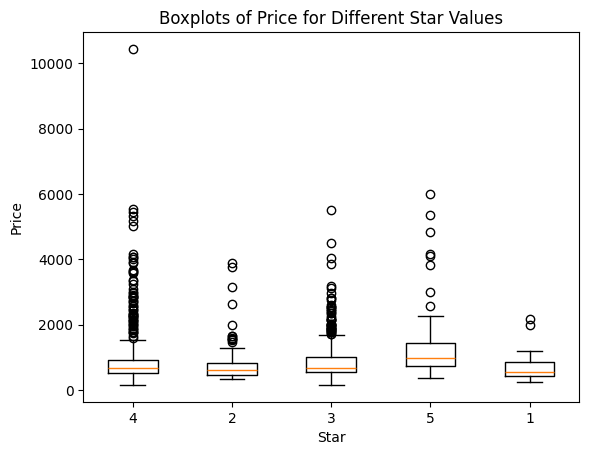

In [8]:
# Group the DataFrame by the 'Stars' column and create boxplots for each group
plt.boxplot([df['Price'][df['Stars'] == star] for star in df['Stars'].unique()], 
            labels=df['Stars'].unique())
plt.xlabel('Star')
plt.ylabel('Price')
plt.title('Boxplots of Price for Different Star Values')
plt.show()

We observe the distribution of prices among different types of hotels. The average prices per star category appear to be quite realistic. We have identified some outliers, and after manual verification, we confirmed that these observations accurately reflect the data as presented on booking.com. We have chosen not to remove them, as we believe that the policies of these particular high-end hotels may significantly influence the results of our estimation.

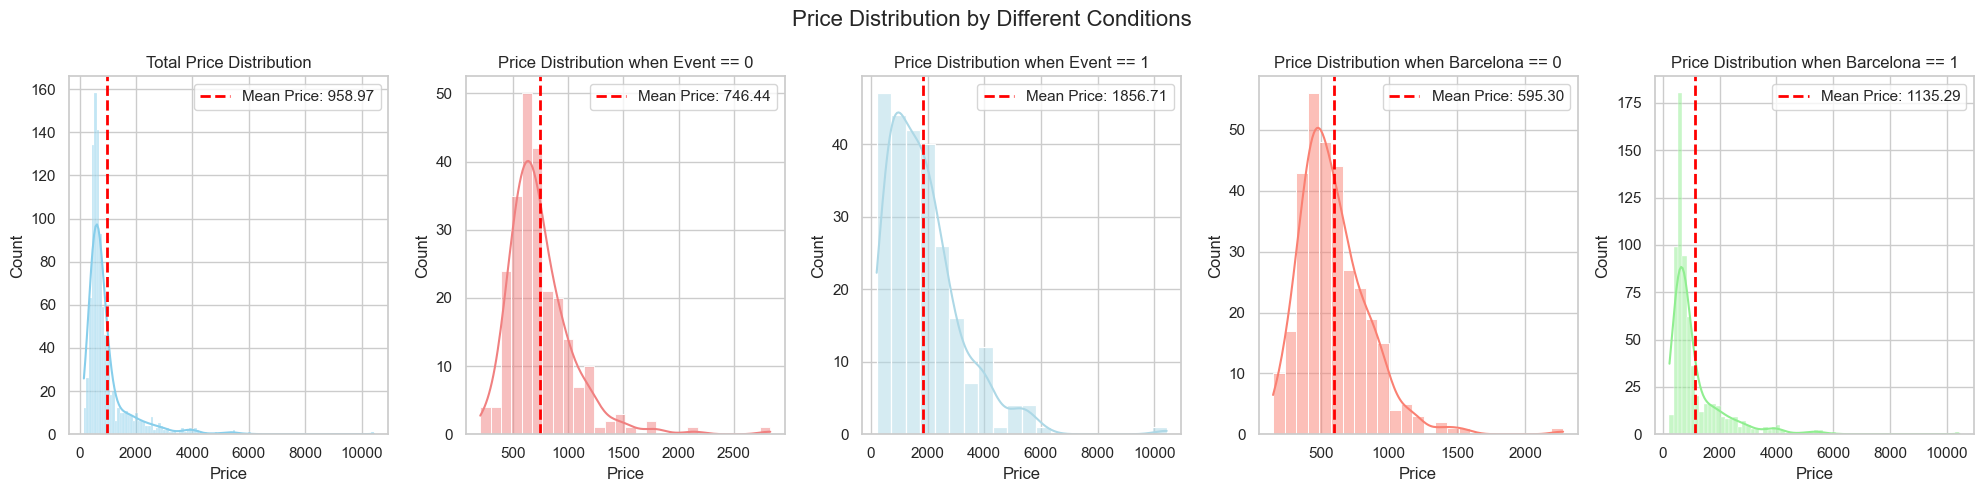

In [9]:
# Set the style for the plot
sns.set(style="whitegrid")

# Create a figure and define subplots
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

# Plot the distribution of 'Price' for all observations
sns.histplot(df['Price'], ax=axes[0], kde=True, color='skyblue')
axes[0].set_title('Total Price Distribution')
mean_price_total = df['Price'].mean()
axes[0].axvline(mean_price_total, color='red', linestyle='dashed', linewidth=2, label=f'Mean Price: {mean_price_total:.2f}')
axes[0].legend()

# Create a separate plot for 'event' == 0
sns.histplot(df[df['event'] == 0]['Price'], ax=axes[1], kde=True, color='lightcoral')
axes[1].set_title('Price Distribution when Event == 0')
mean_price_event_0 = df[df['event'] == 0]['Price'].mean()
axes[1].axvline(mean_price_event_0, color='red', linestyle='dashed', linewidth=2, label=f'Mean Price: {mean_price_event_0:.2f}')
axes[1].legend()

# Create a separate plot for 'event' == 1
sns.histplot(df[df['event'] == 1]['Price'], ax=axes[2], kde=True, color='lightblue')
axes[2].set_title('Price Distribution when Event == 1')
mean_price_event_1 = df[df['event'] == 1]['Price'].mean()
axes[2].axvline(mean_price_event_1, color='red', linestyle='dashed', linewidth=2, label=f'Mean Price: {mean_price_event_1:.2f}')
axes[2].legend()

# Create a separate plot for 'barcelona' == 0
sns.histplot(df[df['barcelona'] == 0]['Price'], ax=axes[3], kde=True, color='salmon')
axes[3].set_title('Price Distribution when Barcelona == 0')
mean_price_barcelona_0 = df[df['barcelona'] == 0]['Price'].mean()
axes[3].axvline(mean_price_barcelona_0, color='red', linestyle='dashed', linewidth=2, label=f'Mean Price: {mean_price_barcelona_0:.2f}')
axes[3].legend()

# Create a separate plot for 'barcelona' == 1
sns.histplot(df[df['barcelona'] == 1]['Price'], ax=axes[4], kde=True, color='lightgreen')
axes[4].set_title('Price Distribution when Barcelona == 1')
mean_price_barcelona_1 = df[df['barcelona'] == 1]['Price'].mean()
axes[4].axvline(mean_price_barcelona_1, color='red', linestyle='dashed', linewidth=2, label=f'Mean Price: {mean_price_barcelona_1:.2f}')
axes[4].legend()

# Add a title to the overall figure
fig.suptitle('Price Distribution by Different Conditions', fontsize=16)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the individual plots
plt.show()

We can observe from the price distributions that they are positively skewed, which is expected. However, we have chosen not to work with the natural logarithm of prices, as it is a common practice for the difference-in-difference model. Additionally, we notice that, as expected, average prices are higher in Barcelona and during the event.

## Common Trend

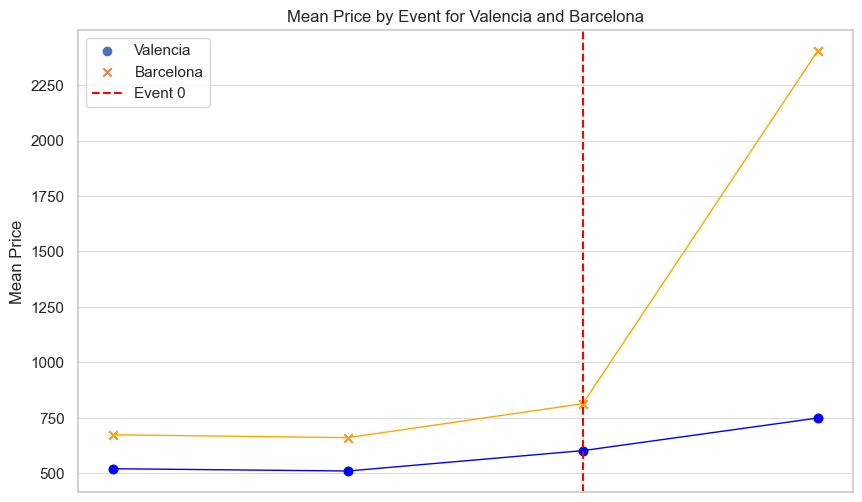

In [10]:
# Calculate the mean Price for each unique event and Barcelona combination
df_means = df.groupby(['event', 'barcelona'])['Price'].mean().reset_index()

# Filter the DataFrame for 'barcelona' == 0 and 'barcelona' == 1
barcelona_0 = df_means[df_means['barcelona'] == 0]
barcelona_1 = df_means[df_means['barcelona'] == 1]

# Create the plot with less bold labels and lines
plt.figure(figsize=(10, 6))
plt.scatter(x='event', y='Price', data=barcelona_0, label='Valencia', marker='o')
plt.scatter(x='event', y='Price', data=barcelona_1, label='Barcelona', marker='x')
plt.plot(barcelona_0['event'], barcelona_0['Price'], linestyle='-', marker='o', color='blue', lw=1)
plt.plot(barcelona_1['event'], barcelona_1['Price'], linestyle='-', marker='x', color='orange', lw=1)
plt.axvline(x=0, color='red', linestyle='--', label='Event 0')  # Add vertical line at 'event' == 0
plt.xlabel('')
plt.ylabel('Mean Price', fontweight='light')  # Less bold font for the y-axis label
plt.title('Mean Price by Event for Valencia and Barcelona', fontweight='light')  # Less bold font for the title
plt.legend()
plt.grid(True, linewidth=0.5)  # Thin grid lines

# Remove x-axis labels
plt.xticks([])

plt.show()

In the graph, we observe a common trend between the treated and control groups of hotels, at least during a certain period of time. There is a slight difference in the rate of price changes between Barcelona and Valencia, so we plan to address this difference in trend in our analysis. Additionally, the graph clearly shows a significant increase in prices in Barcelona during the event.

## Regressions

In [11]:
# Subset rows where 'event' is equal to 1 or 0
df = df[df['event'].isin([1, 0])]

In [12]:
# Independent variables
X = df[['barcelona']]

# Dependent variable
y = df['Price']

# Add a constant (intercept)
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     87.78
Date:                Sun, 04 Feb 2024   Prob (F-statistic):           2.77e-19
Time:                        18:05:47   Log-Likelihood:                -4065.8
No. Observations:                 487   AIC:                             8136.
Df Residuals:                     485   BIC:                             8144.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        677.4557     81.492      8.313      0.0

In [13]:
# Independent variables
X = df[['event']]

# Dependent variable
y = df['Price']

# Add a constant (intercept)
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     161.4
Date:                Sun, 04 Feb 2024   Prob (F-statistic):           3.99e-32
Time:                        18:05:48   Log-Likelihood:                -4036.4
No. Observations:                 487   AIC:                             8077.
Df Residuals:                     485   BIC:                             8085.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        746.4380     61.983     12.043      0.0

In [14]:
# Adding the interaction term
df['interaction_term'] = df['barcelona'] * df['event']

# Independent variables
X = df[['barcelona', 'event', 'interaction_term']]

# Dependent variable
y = df['Price']

# Add a constant (intercept)
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     161.4
Date:                Sun, 04 Feb 2024   Prob (F-statistic):           1.83e-72
Time:                        18:05:48   Log-Likelihood:                -3937.2
No. Observations:                 487   AIC:                             7882.
Df Residuals:                     483   BIC:                             7899.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              602.1169     89.831  

In line with our expectations, we observe a positive and statistically significant coefficient for the interaction term. This result essentially implies that, on average, hosting an event in Barcelona is associated with an increase in hotel prices by €1,443.

In [15]:
def calculate_share_and_count(df, barcelona_val, event_val):
    filter_condition = (df['barcelona'] == barcelona_val) & (df['event'] == event_val)
    filtered_df = df[filter_condition]

    num_observations = len(filtered_df)

    if num_observations > 0:
        share_stars_4_or_5 = len(filtered_df[filtered_df['Stars'].isin([4, 5])]) / num_observations
    else:
        share_stars_4_or_5 = 0

    return num_observations, share_stars_4_or_5

# Calculate for barcelona=1 and event=1
num_observation_1, share_1 = calculate_share_and_count(df, 1, 1)

# Calculate for barcelona=0 and event=1
num_observation_0, share_0 = calculate_share_and_count(df, 0, 1)

print("Number of Observations where barcelona=1 and event=1:", num_observation_1)
print("Share of 'Stars' equal to 4 or 5 for these observations:", share_1)

print("Number of Observations where barcelona=0 and event=1:", num_observation_0)
print("Share of 'Stars' equal to 4 or 5 for these observations:", share_0)

Number of Observations where barcelona=1 and event=1: 164
Share of 'Stars' equal to 4 or 5 for these observations: 0.4878048780487805
Number of Observations where barcelona=0 and event=1: 81
Share of 'Stars' equal to 4 or 5 for these observations: 0.654320987654321


The share of 5-4 star hotels in both cities differs noticeably, with Valencia having a 17 percentage point higher share. This observation suggests that prices for top-tier hotels may increase more significantly. However, considering that Barcelona actually has a lower share of top hotels, it becomes evident that without controlling for this aspect of the trend, we may underestimate the effect of the event.

In [16]:
# Adding the interaction term
df['interaction_term'] = df['barcelona'] * df['event']

# Independent variables
X = df[['barcelona', 'event', 'Stars', 'interaction_term']]

# Add a constant (intercept)
X = sm.add_constant(X)

# Dependent variable
y = df['Price']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     139.7
Date:                Sun, 04 Feb 2024   Prob (F-statistic):           3.44e-79
Time:                        18:05:51   Log-Likelihood:                -3918.9
No. Observations:                 487   AIC:                             7848.
Df Residuals:                     482   BIC:                             7869.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -350.3501    177.529  

As expected, controlling for star ratings enables us to capture the average treatment effect more accurately. We observe that both the coefficients of the 'Stars' variable and the interaction term are statistically significant. Notably, the coefficient of the interaction term is a bit lower than it was without controlling for stars, indicating that the actual average treatment effect is slightly lower.

In [17]:
# Extract only digits from the 'Distance' column and convert to numeric
df['Distance'] = pd.to_numeric(df['Distance'].str.replace(',', '.').str.extract('([\d.]+)', expand=False), errors='coerce')

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\gatla\AppData\Local\Temp\ipykernel_18336\1007185113.py:2: SyntaxWarning: invalid escape sequence '\d'
  df['Distance'] = pd.to_numeric(df['Distance'].str.replace(',', '.').str.extract('([\d.]+)', expand=False), errors='coerce')


In [18]:
def calculate_statistics(df, barcelona_val, event_val):
    # Filter the DataFrame for the specified conditions
    filtered_df = df[(df['barcelona'] == barcelona_val) & (df['event'] == event_val)]

    # Calculate the average 'Distance'
    avg_distance = filtered_df['Distance'].mean()

    # Calculate the maximum 'Distance'
    max_distance = filtered_df['Distance'].max()

    # Calculate the minimum 'Distance'
    min_distance = filtered_df['Distance'].min()

    return avg_distance, max_distance, min_distance

# Calculate statistics for barcelona=1 and event=1
avg_1, max_1, min_1 = calculate_statistics(df, 1, 1)
print("For barcelona=1 and event=1:")
print("Average Distance:", avg_1)
print("Maximum Distance:", max_1)
print("Minimum Distance:", min_1)

# Calculate statistics for barcelona=0 and event=1
avg_0, max_0, min_0 = calculate_statistics(df, 0, 1)
print("For barcelona=0 and event=1:")
print("Average Distance:", avg_0)
print("Maximum Distance:", max_0)
print("Minimum Distance:", min_0)

For barcelona=1 and event=1:
Average Distance: 43.28719512195122
Maximum Distance: 500.0
Minimum Distance: 0.5
For barcelona=0 and event=1:
Average Distance: 37.34567901234568
Maximum Distance: 450.0
Minimum Distance: 0.5


The average distance in Barcelona is slightly larger. Therefore, it is possible that with the increase in prices in Valencia, the prices for hotels closer to the city center will grow slightly faster. This could introduce some bias into our analysis.

In [19]:
# Adding the interaction term
df['interaction_term'] = df['barcelona'] * df['event']

# Independent variables
X = df[['barcelona', 'event', 'Distance', 'Stars', 'interaction_term']]

# Add a constant (intercept)
X = sm.add_constant(X)

# Dependent variable
y = df['Price']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     114.8
Date:                Sun, 04 Feb 2024   Prob (F-statistic):           1.05e-79
Time:                        18:05:54   Log-Likelihood:                -3915.1
No. Observations:                 487   AIC:                             7842.
Df Residuals:                     481   BIC:                             7867.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -338.2383    176.393  

The significant coefficient of the 'Distance' variable suggests that distance to the city center is associated with changes in hotel prices, and when included in the model, it can help improve the precision of your estimates and reduce potential bias.

# Processing descriptions

In [20]:
df.head()

,Hotels,Distance,District,Price,Rating,Stars,Comments,Link,Descriptions,event,barcelona,descriptions,interaction_term
1377,Hotel Ronda Lesseps,3.0,"Gracia, Barcelona",472,"8,3",4,2.115 comentarios,https://www.booking.com/hotel/es/rondalessepsb...,El Hotel Ronda Lesseps es un establecimiento t...,0,1,NaN,0
1381,Hostal Boqueria,0.6,"Ciutat Vella, Barcelona",738,"8,4",2,731 comentarios,https://www.booking.com/hotel/es/hostal-boquer...,Este establecimiento se encuentra en las Rambl...,0,1,NaN,0
1388,Hostal Las Flores Ramblas,0.7,"Ciutat Vella, Barcelona",692,"8,2",2,1.362 comentarios,https://www.booking.com/hotel/es/hostal-las-fl...,Este céntrico hotel se encuentra en Las Rambla...,0,1,NaN,0
1390,Pensión San Ramón,1.0,"Ciutat Vella, Barcelona",333,"6,4",1,1.717 comentarios,https://www.booking.com/hotel/es/pensia3n-host...,La Pensión San Ramón se encuentra en el barrio...,0,1,NaN,0
1391,Catalonia Sagrada Familia,2.6,"Sant Martí, Barcelona",606,"8,2",3,7.803 comentarios,https://www.booking.com/hotel/es/cataloniaarag...,El Catalonia Sagrada Familia se halla a 15 min...,0,1,NaN,0


In [21]:
def abbr_or_lower(word):
    if re.match('([A-Z]+[a-z]*){2,}', word):
        return word
    else:
        return word.lower()

In [22]:
# Remove special characters
df['processed_text'] = df['Descriptions'].apply(lambda x: re.sub(r'\W', ' ', str(x)) if pd.notna(x) else '')

# Lowercase words that are not abbreviations
df['processed_text'] = df['processed_text'].apply(lambda x: ' '.join(abbr_or_lower(word) for word in x.split()))

# Remove stopwords
stop_words = set(stopwords.words("spanish"))
df['processed_text'] = df['processed_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Apply stemming
stemmer = PorterStemmer()
df['processed_text'] = df['processed_text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
    

### Creating Document Term Matrix (DTM)

In [23]:
# Create document term matrix of both unigrams and bigrams using CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1,2), min_df=0.05, max_df=0.3)
X = vectorizer.fit_transform(df['processed_text'])

# Convert DTM to DataFrame
dtm_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
dtm_df

,10,10 minuto,100,100 metro,11,12,12 km,13,13 km,14,...,vario,virgen,virgen desamparado,vista ciudad,volver,volver aeropuerto,vía,vía satélit,wi,wi fi
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
483,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,0,0
484,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
485,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Looking for most popular words from DTM

In [24]:
# Get feature names and TF-IDF scores
feature_names = vectorizer.get_feature_names_out()
dtm_scores = X.toarray()

# Create a DataFrame to display the top words and their TF-IDF scores
dtm_df = pd.DataFrame(dtm_scores, columns=feature_names)

# Display the top words and their TF-IDF scores
top_words_dtm = dtm_df.sum(axis=0).sort_values(ascending=False)
print(top_words_dtm[:25])

apartamento        329
playa              195
establecimiento    189
desayuno           163
dispon             161
solo               160
ademá              156
piscina            154
km alojamiento     153
vía                150
10                 149
elegant            149
sirv               149
cama               147
gratuito           146
cerca              144
satélit            138
bar                137
disponen           136
vía satélit        136
10 minuto          131
cercano            130
incluyen           130
aseo               128
artículo aseo      124
dtype: int64


Based on some of the most popular words, we will create a Technological amenities, which will signify if a hotel outlines in its description that it offers WiFi or satellite tv. We believe this will be useful in controlling for differences in hotels between Barcelona and Valencia across the two periods.

### Creating Term Frequency (TF)-Inverse Document Frequency (IDF) matrix

In [25]:
# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=0.05, max_df=0.40)
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text'])

# Convert TF-IDF to DataFrame
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

tfidf_df

,10,10 minuto,100,100 metro,11,12,12 km,13,13 km,14,...,vista,vista ciudad,volver,volver aeropuerto,vía,vía satélit,wi,wi fi,wifi grati,zona
0,0.166761,0.175371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.097682,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.098246
2,0.117700,0.123776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.133959
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.093493,0.000000
483,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.076119,0.104212,0.0,0.0,0.0,0.0,0.000000,0.000000,0.081020,0.076558
484,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.075194,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.080036,0.000000
485,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.105814,0.000000


### Looking for most popular words from tfidf matrix

Intuition behind this - When a term has a high sum of TF-IDF scores across hotel descriptions, it indicates that the term is not only frequently occurring within individual descriptions (high Term Frequency, TF) but also has a relatively low frequency across the entire collection of desciptions (high Inverse Document Frequency, IDF). This combination suggests that the term is both important and unique to certain hotels, so these terms are likely to be useful to include as indicator variables in the regression analysis.

In [26]:
# Get feature names and TF-IDF scores
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = X_tfidf.toarray()

# Create a DataFrame to display the top words and their TF-IDF scores
tfidf_df = pd.DataFrame(tfidf_scores, columns=feature_names)

# Display the top words and their TF-IDF scores
top_words_tfidf = tfidf_df.sum(axis=0).sort_values(ascending=False)
print(top_words_tfidf[:25])

valencia           36.609860
apartamento        31.658760
rambla             21.269652
playa              19.468161
zona               18.908923
plaza              18.712797
servicio           18.671370
ciudad             18.667070
establecimiento    18.508106
vista              16.285176
estación metro     16.249769
terraza            16.090824
toda               16.020073
barrio             15.665502
cuenta             15.528420
situado            15.517748
solo               15.502923
10                 15.402893
km alojamiento     15.154570
elegant            15.123786
dispon             14.797052
piscina            14.729416
recepción          14.667549
ademá              14.649927
desayuno           14.513847
dtype: float64


Based on the list of words, we will include indicator variables for "terraza" and "piscina", as they both have a high sum of TF-IDF scores and are most likely to help control for differences in hotels between Barcelona and Valencia.

### Summary statistics for chosen features

In [27]:
# Technological amenities dummy
df['tech_amenities'] = df['processed_text'].apply(lambda x: 1 if any(word in x for word in ['ofrec wifi', 'satélit']) else 0)

In [28]:
# Creating dummy variables for "terraza" and "piscina"
df['piscina'] = df['processed_text'].apply(lambda x: 1 if 'piscina' in x else 0)
df['terraza'] = df['processed_text'].apply(lambda x: 1 if 'terraza' in x else 0)

In [29]:
# Summary stats for features
print("Percentage of Barcelona hotels with 'terraza' in the description: " + str(round(df[df['barcelona'] == 1]['terraza'].mean() * 100)) + "%")
print("Percentage of Valencia hotels with 'terraza' in the description: " + str(round(df[df['barcelona'] == 0]['terraza'].mean() * 100)) + "%")
print('\n')
print("Percentage of Barcelona hotels with 'piscina' in the description: " + str(round(df[df['barcelona'] == 1]['piscina'].mean() * 100)) + "%")
print("Percentage of Valencia hotels with 'piscina' in the description: " + str(round(df[df['barcelona'] == 0]['piscina'].mean() * 100)) + "%")
print('\n')
print("Percentage of Barcelona hotels with technological amenities in the description: " + str(round(df[df['barcelona'] == 1]['tech_amenities'].mean() * 100)) + "%")
print("Percentage of Valencia hotels with technological amenities in the description: " + str(round(df[df['barcelona'] == 0]['tech_amenities'].mean() * 100)) + "%")

Percentage of Barcelona hotels with 'terraza' in the description: 40%
Percentage of Valencia hotels with 'terraza' in the description: 26%


Percentage of Barcelona hotels with 'piscina' in the description: 35%
Percentage of Valencia hotels with 'piscina' in the description: 9%


Percentage of Barcelona hotels with technological amenities in the description: 39%
Percentage of Valencia hotels with technological amenities in the description: 34%


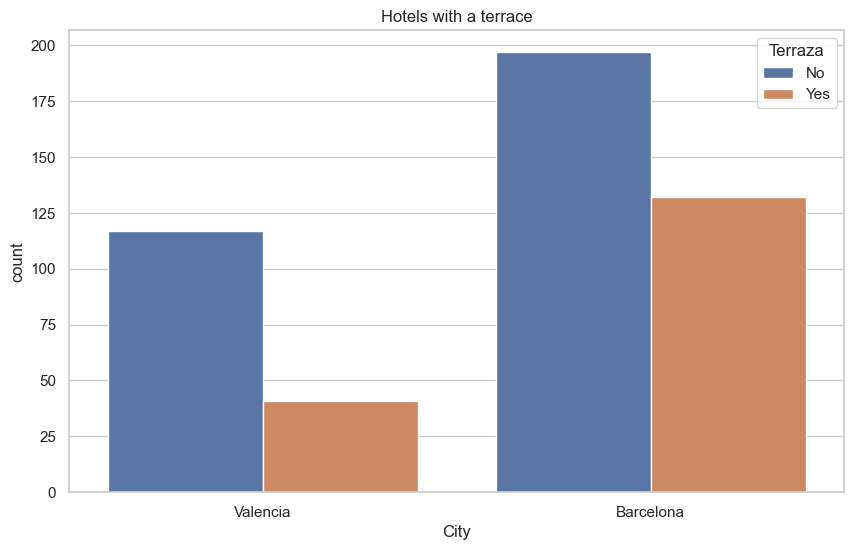

In [30]:
# Plot for terraza

df['Terraza'] = df['terraza'].map({0: 'No', 1: 'Yes'})

plt.figure(figsize=(10, 6))
sns.countplot(x='barcelona', hue='Terraza', data=df, hue_order=['No', 'Yes'])
plt.title('Hotels with a terrace')
plt.xlabel('City')
plt.xticks([0, 1], ['Valencia', 'Barcelona'])
plt.show()

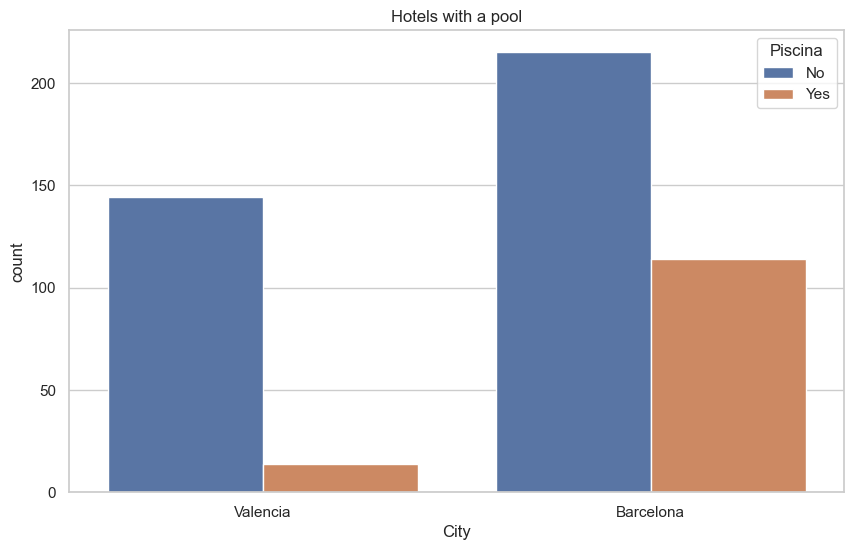

In [31]:
# Plot for piscina

df['Piscina'] = df['piscina'].map({0: 'No', 1: 'Yes'})

plt.figure(figsize=(10, 6))
sns.countplot(x='barcelona', hue='Piscina', data=df, hue_order=['No', 'Yes'])
plt.title('Hotels with a pool')
plt.xlabel('City')
plt.xticks([0, 1], ['Valencia', 'Barcelona'])
plt.show()

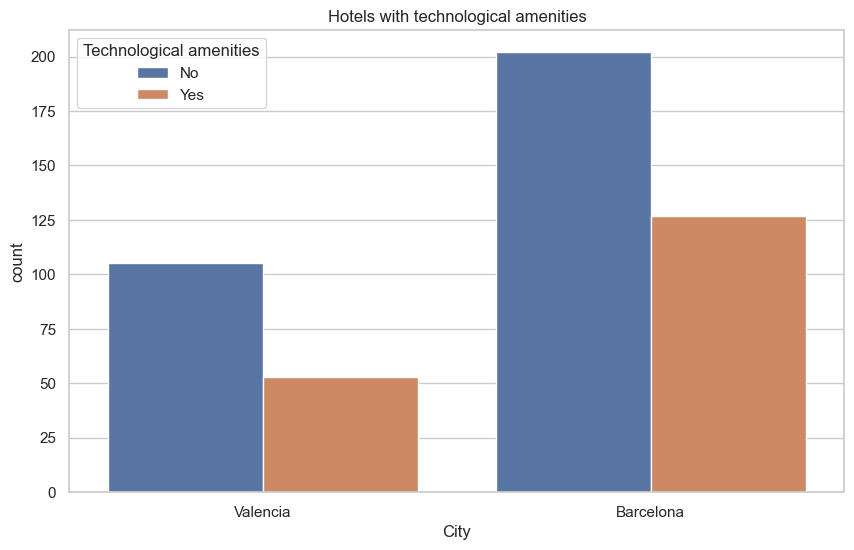

In [32]:
# Plot for technological amenities

df['Technological amenities'] = df['tech_amenities'].map({0: 'No', 1: 'Yes'})

plt.figure(figsize=(10, 6))
sns.countplot(x='barcelona', hue='Technological amenities', data=df, hue_order=['No', 'Yes'])
plt.title('Hotels with technological amenities')
plt.xlabel('City')
plt.xticks([0, 1], ['Valencia', 'Barcelona'])
plt.show()

### Final regressions with added features

In [33]:
# Independent variables
X = df[['barcelona', 'event', 'Distance', 'Stars', 'interaction_term', 'piscina', 'terraza', 'tech_amenities']]

# Add a constant (intercept)
X = sm.add_constant(X)

# Dependent variable
y = df['Price']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     80.29
Date:                Sun, 04 Feb 2024   Prob (F-statistic):           1.73e-83
Time:                        18:06:15   Log-Likelihood:                -3898.9
No. Observations:                 487   AIC:                             7816.
Df Residuals:                     478   BIC:                             7854.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -192.1812    174.786  

The interaction term of interest remains consistent with the other regressions, with the results implying that on average, hosting MWC in Barcelona is associated with an increase in hotel prices by 1,428 EUR. This implies that the previous regressions were already capturing the majority of the effect of the event, even without the additional controls.

### Sentiment Analysis

We attempted to perform sentiment analysis on the hotel descriptions using the below code. However, the majority of descriptions had a neutral sentiment, so we decided to not use this as a feature in our regression analysis.

In [34]:
def calculate_sentiment(description):
    if isinstance(description, str):
        return TextBlob(description).sentiment.polarity
    else:
        # Return 0 for NaN values
        return 0 

# Apply the function to the 'Descriptions' column
df['sentiment'] = df['Descriptions'].apply(calculate_sentiment)
df

,Hotels,Distance,District,Price,Rating,Stars,Comments,Link,Descriptions,event,...,descriptions,interaction_term,processed_text,tech_amenities,piscina,terraza,Terraza,Piscina,Technological amenities,sentiment
1377,Hotel Ronda Lesseps,3.0,"Gracia, Barcelona",472,"8,3",4,2.115 comentarios,https://www.booking.com/hotel/es/rondalessepsb...,El Hotel Ronda Lesseps es un establecimiento t...,0,...,NaN,0,hotel ronda lessep establecimiento tranquilo f...,0,0,1,Yes,No,No,0.375000
1381,Hostal Boqueria,0.6,"Ciutat Vella, Barcelona",738,"8,4",2,731 comentarios,https://www.booking.com/hotel/es/hostal-boquer...,Este establecimiento se encuentra en las Rambl...,0,...,NaN,0,establecimiento encuentra rambla barcelona men...,0,0,0,No,No,No,0.900000
1388,Hostal Las Flores Ramblas,0.7,"Ciutat Vella, Barcelona",692,"8,2",2,1.362 comentarios,https://www.booking.com/hotel/es/hostal-las-fl...,Este céntrico hotel se encuentra en Las Rambla...,0,...,NaN,0,céntrico hotel encuentra rambla barcelona junt...,0,0,0,No,No,No,0.000000
1390,Pensión San Ramón,1.0,"Ciutat Vella, Barcelona",333,"6,4",1,1.717 comentarios,https://www.booking.com/hotel/es/pensia3n-host...,La Pensión San Ramón se encuentra en el barrio...,0,...,NaN,0,pensión san ramón encuentra barrio barceloné r...,0,0,0,No,No,No,0.000000
1391,Catalonia Sagrada Familia,2.6,"Sant Martí, Barcelona",606,"8,2",3,7.803 comentarios,https://www.booking.com/hotel/es/cataloniaarag...,El Catalonia Sagrada Familia se halla a 15 min...,0,...,NaN,0,catalonia sagrada familia halla 15 minuto pie ...,0,1,0,No,Yes,No,0.107143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4613,Hrooms Estudio Boutique,0.7,"Poblados marítimos, Valencia",608,"6,1",4,17 comentarios,https://www.booking.com/hotel/es/hrooms-estudi...,Hrooms Estudio Boutique ofrece alojamiento con...,1,...,NaN,0,hroom estudio boutiqu ofrec alojamiento ubicac...,1,0,0,No,No,Yes,0.900000
4616,MD Balmes Central Market,0.6,"Ciutat Vella, Valencia",919,"9,2",3,91 comentarios,https://www.booking.com/hotel/es/balmes-1-6-pa...,MD Balmes Central Market ofrece alojamiento co...,1,...,NaN,0,md balm central market ofrec alojamiento air a...,1,0,0,No,No,Yes,0.000000
4620,Valencia/Mare Nostrum,5.0,"Extramurs, Valencia",727,"8,6",4,47 comentarios,https://www.booking.com/hotel/es/valencia-blue...,"Valencia/Mare Nostrum, que tiene piscina de te...",1,...,NaN,0,valencia mare nostrum piscina temporada air li...,0,1,0,No,Yes,No,0.900000
4627,Château Angélique,27.4,"Benicalap, Valencia",495,"8,2",4,45 comentarios,https://www.booking.com/hotel/es/chateau-angel...,Château Angélique es un alojamiento con jardín...,1,...,NaN,0,château angéliqu alojamiento jardín terraza va...,1,0,1,Yes,No,Yes,0.000000
